<a href="https://colab.research.google.com/github/abcardoso/ifes_ann/blob/main/202401_ANN_Note02_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando o MNIST
- Importa o MNIST e adiciona em arrays do Numpy
- Salva no arquivo mnistAna.npz

In [ ]:
import gzip
import sys
import struct
import urllib.request
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11",
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnistDaAna',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )

data = np.load('mnistDaAna.npz')

print(data['train_x'].shape, data['train_x'].dtype) #imagens de treino 28 colunas x 28 linhas
print(data['train_y'].shape, data['train_y'].dtype) #labels de treino
print(data['test_x'].shape, data['test_x'].dtype) #imagens de teste 28 colunas x 28 linhas
print(data['test_y'].shape, data['test_y'].dtype) #labels de teste

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


Plotando para validar

3


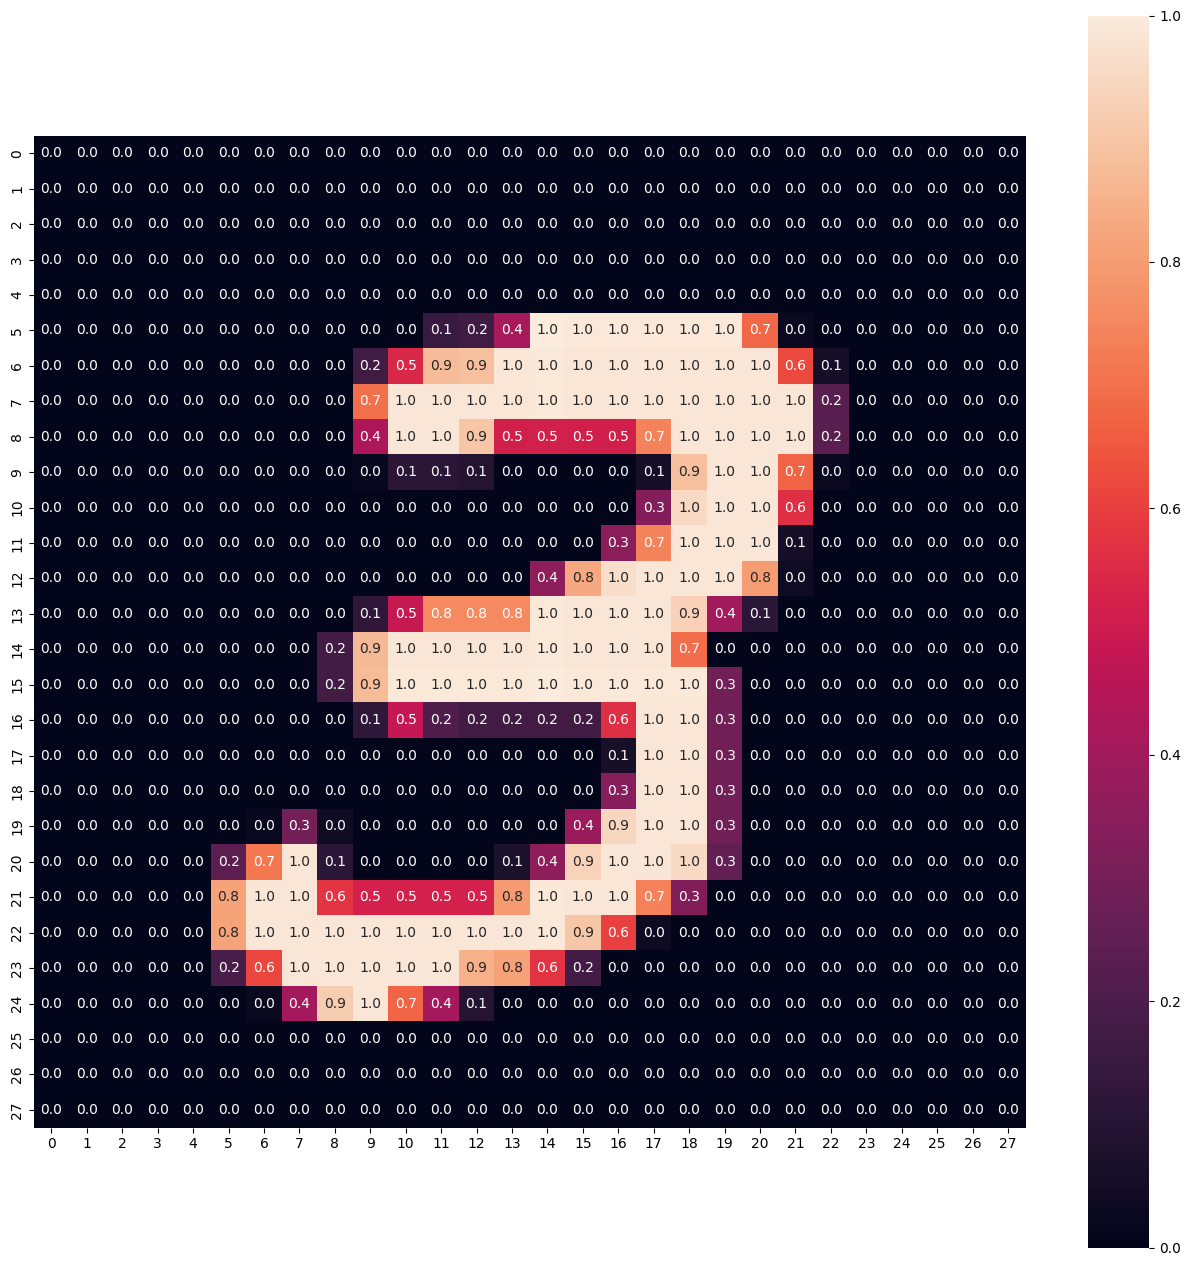

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# A instancia que vamos plotar
i = 7 #exemplo indice 7 é label 3

data = np.load('mnistDaAna.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True)
plt.show()

Definindo a arquitetura e modelo

In [27]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import numpy as np

def define_architecture(input_shape, output_shape):
  inputs = keras.Input(shape=input_shape)

  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
  x = layers.MaxPool2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)

  outputs = layers.Dense(output_shape, activation="softmax")(x)
  return keras.Model(inputs=inputs, outputs=outputs)

class RedeNeural(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = define_architecture(X.shape[1:], yhot.shape[1])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self

  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    ypred = self.labels[np.argmax(probabilities, axis=1)]
    return ypred

class DividePor255(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return np.array(X, dtype="float32") / 255

class MudaShape(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    # [n_samples, height, width, channels] - n_samples é -1 para flexibilizar o tamanho, calcula automaticamente; 28 por 28 é o tamanho da imagem; canal é 1 porque preto e branco.
    return X.reshape((-1, 28, 28, 1))

modelo = Pipeline([
    ("scaler", DividePor255()),
    ("reshape", MudaShape()),
    ("ann", RedeNeural())
])
(data['train_x'], data['train_y']), (data['test_x'], data['test_y']) # Aqui eu uso os meus datasets extraídos do arquivo mnistDaAna
modelo.fit(data['train_x'],  data['train_y'])
ypred = modelo.predict(data['test_x'])
accuracy_score(np.array(data['test_y']), ypred)

Epoch 1/5
469/469 [==============================] - 47s 98ms/step - loss: 2.3012 - accuracy: 0.1117
Epoch 2/5
469/469 [==============================] - 46s 98ms/step - loss: 1.1446 - accuracy: 0.6455
Epoch 3/5
469/469 [==============================] - 47s 101ms/step - loss: 0.3926 - accuracy: 0.8802
Epoch 4/5
469/469 [==============================] - 46s 98ms/step - loss: 0.2454 - accuracy: 0.9261
Epoch 5/5
313/313 [==============================] - 3s 8ms/step


0.9624